导入包

In [112]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import math
import random
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score,plot_roc_curve
from sklearn.model_selection import learning_curve,cross_val_score,KFold
from catboost import CatBoostClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2
from cmath import isnan
import time
sns.set(style='darkgrid', font_scale=1.4)

选用模型KNN, SVM, Decision Tree, RandomForest, NaiveBayes, CatBoost

In [113]:
data = pd.read_csv('..\dataset\spaceship-titanic\\encode.csv')
train_set = pd.read_csv('..\dataset\spaceship-titanic\\train.csv')
test_set = pd.read_csv('..\dataset\spaceship-titanic\\test.csv')

In [114]:
train, x_test = data.iloc[:train_set.shape[0]], data.iloc[train_set.shape[0]:].drop(['Transported'], axis=1)
x_train, y_train = train.drop(['Transported'], axis=1), train['Transported']
y_test = pd.read_csv('..\dataset\spaceship-titanic\\sample_submission.csv')

X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=43, stratify=y_train)

In [115]:
i = 0 
for train_index , test_index in KFold(n_splits=10, shuffle=True, random_state=0).split(x_train,y_train):  
    print("{",i,"FOLD}","Train Count:",len(train_index),"  Test Count:",len(test_index))
    i= i + 1 

{ 0 FOLD} Train Count: 7823   Test Count: 870
{ 1 FOLD} Train Count: 7823   Test Count: 870
{ 2 FOLD} Train Count: 7823   Test Count: 870
{ 3 FOLD} Train Count: 7824   Test Count: 869
{ 4 FOLD} Train Count: 7824   Test Count: 869
{ 5 FOLD} Train Count: 7824   Test Count: 869
{ 6 FOLD} Train Count: 7824   Test Count: 869
{ 7 FOLD} Train Count: 7824   Test Count: 869
{ 8 FOLD} Train Count: 7824   Test Count: 869
{ 9 FOLD} Train Count: 7824   Test Count: 869


In [116]:
# Classifiers
classifiers = {
    "KNN" : KNeighborsClassifier(),
    "SVC" : SVC(random_state=0, probability=True),
    "DesicionTree": DecisionTreeClassifier(random_state=0, criterion='gini'),
    "RandomForest" : RandomForestClassifier(random_state=0),
    "CatBoost" : CatBoostClassifier(random_state=0, verbose=False),
    "NaiveBayes": GaussianNB()
}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

SVC_grid = {'C': [0.5, 0.75, 1, 1.25, 1.5, 1.75],
            'kernel': ['rbf'],
            'gamma': ['scale']}

DT_grid={'max_depth': [5, 7, 9, 11],
         'criterion':['gini','entropy']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

NB_grid={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

# Dictionary of all grids
grid = {
    "KNN" : KNN_grid,
    "SVC" : SVC_grid,
    "DesicionTree": DT_grid,
    "RandomForest" : RF_grid,
    "NaiveBayes": NB_grid,
    "CatBoost" : boosted_grid
}

In [117]:
i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train, Y_train)
    valid_scores.iloc[i,1]=clf.score(X_test, Y_test)

    # Save trained model
    clf_best_params[key]=clf.best_params_
    
    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i+=1

Model: KNN
Training time (mins): 0.26

Model: SVC
Training time (mins): 0.53

Model: DesicionTree
Training time (mins): 0.0

Model: RandomForest
Training time (mins): 0.2



d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Model: CatBoost
Training time (mins): 5.52

Model: NaiveBayes
Training time (mins): 0.0



In [118]:
clf_best_params

{'KNN': {'n_neighbors': 9, 'p': 1},
 'SVC': {'C': 1.75, 'gamma': 'scale', 'kernel': 'rbf'},
 'DesicionTree': {'criterion': 'gini', 'max_depth': 7},
 'RandomForest': {'max_depth': 10, 'n_estimators': 100},
 'CatBoost': {'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 150},
 'NaiveBayes': {'var_smoothing': 1e-07}}

KNN聚类

{ 1 FOLD} Train Count: 7823   Test Count: 870
Model: KNN     Accuracy: 0.725287356321839      Precision: 0.7359413202933985      Recall: 0.6967592592592593      F1-Score: 0.7158145065398336
{ 2 FOLD} Train Count: 7823   Test Count: 870
Model: KNN     Accuracy: 0.7126436781609196      Precision: 0.7579787234042553      Recall: 0.6418918918918919      F1-Score: 0.6951219512195121
{ 3 FOLD} Train Count: 7823   Test Count: 870
Model: KNN     Accuracy: 0.7172413793103448      Precision: 0.735897435897436      Recall: 0.6674418604651163      F1-Score: 0.7000000000000001
{ 4 FOLD} Train Count: 7824   Test Count: 869
Model: KNN     Accuracy: 0.6950517836593786      Precision: 0.7379679144385026      Recall: 0.6230248306997742      F1-Score: 0.675642594859241
{ 5 FOLD} Train Count: 7824   Test Count: 869
Model: KNN     Accuracy: 0.6915995397008056      Precision: 0.7075      Recall: 0.652073732718894      F1-Score: 0.6786570743405276
{ 6 FOLD} Train Count: 7824   Test Count: 869
Model: KNN     

d:\Anaconda3\envs\datamining\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


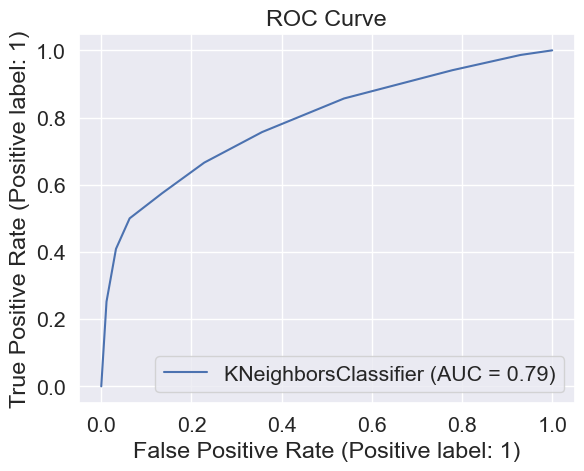

In [119]:
classifier = KNeighborsClassifier(n_neighbors = 9, p=1)
i = 1
accs = []
f1s = []
recs = []
pres = []
cm = np.zeros((2,2))
time_start = time.time()
for train_index , test_index in KFold(n_splits=10, shuffle=True, random_state=0).split(x_train,y_train):  
    print("{",i,"FOLD}","Train Count:",len(train_index),"  Test Count:",len(test_index))
    i= i + 1 
    X_train,X_test = x_train.iloc[train_index],x_train.iloc[test_index]
    Y_train,Y_test = y_train.iloc[train_index],y_train.iloc[test_index]
    classifier.fit(X_train, Y_train)
    pred = classifier.predict(X_test)
    acc = accuracy_score(Y_test,pred)
    f1 = f1_score(Y_test,pred)
    rec = recall_score(Y_test,pred)
    pre = precision_score(Y_test,pred)
    print('Model: KNN     Accuracy:',acc,'     Precision:',pre,'     Recall:',rec,'     F1-Score:',f1)
    accs.append(acc)
    f1s.append(f1)
    recs.append(rec)
    pres.append(pre)
    cm = cm + confusion_matrix(Y_test,pred)

plot_roc_curve(classifier, X_test, Y_test)
plt.title('ROC Curve')
time_end = time.time()
time_knn = time_end - time_start
c_m_knn = np.round(cm / 10).astype(int)
acc_knn = np.mean(accs)
pre_knn = np.mean(pres)
rec_knn = np.mean(recs)
f1_knn = np.mean(f1s)
print("Mean_Accuracy:", np.mean(accs),"     Mean_Precision:", np.mean(pres),"     Mean_Recall:", np.mean(recs),"     Mean_F1-Score:", np.mean(f1s),"     Time:", time_knn)

<AxesSubplot: >

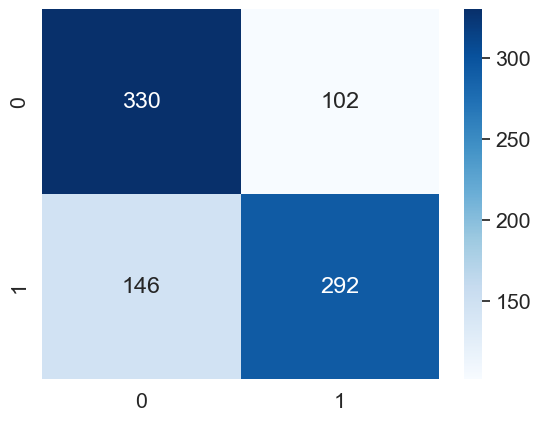

In [120]:
sns.heatmap(c_m_knn, annot=True, cmap='Blues', fmt='g')

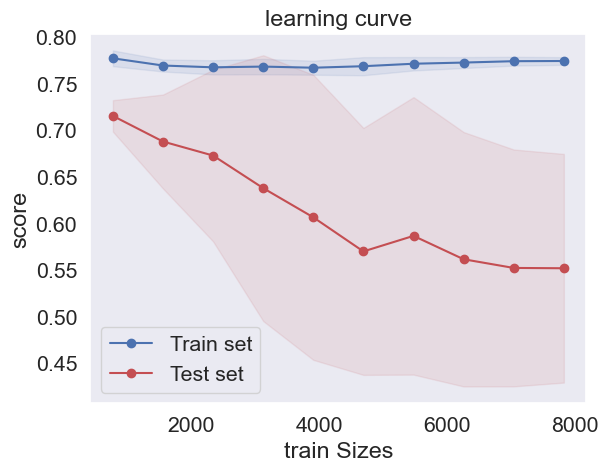

In [121]:
train_sizes,train_scores,test_scores=learning_curve(classifier,x_train,y_train,train_sizes=np.linspace(0.1,1,10),cv=10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.figure()
plt.title('learning curve')

plt.xlabel(u"train Sizes")
plt.ylabel(u"score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"Train set")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"Test set")

plt.legend(loc="best")

SVM支持向量机

{ 1 FOLD} Train Count: 7823   Test Count: 870
Model: SVC     Accuracy: 0.7310344827586207      Precision: 0.7605263157894737      Recall: 0.6689814814814815      F1-Score: 0.7118226600985222
{ 2 FOLD} Train Count: 7823   Test Count: 870
Model: SVC     Accuracy: 0.7241379310344828      Precision: 0.7741935483870968      Recall: 0.6486486486486487      F1-Score: 0.7058823529411764
{ 3 FOLD} Train Count: 7823   Test Count: 870
Model: SVC     Accuracy: 0.7241379310344828      Precision: 0.7567567567567568      Recall: 0.6511627906976745      F1-Score: 0.7000000000000001
{ 4 FOLD} Train Count: 7824   Test Count: 869
Model: SVC     Accuracy: 0.7272727272727273      Precision: 0.7959770114942529      Recall: 0.6252821670428894      F1-Score: 0.7003792667509482
{ 5 FOLD} Train Count: 7824   Test Count: 869
Model: SVC     Accuracy: 0.7054085155350979      Precision: 0.7317708333333334      Recall: 0.6474654377880185      F1-Score: 0.6870415647921762
{ 6 FOLD} Train Count: 7824   Test Count: 869

d:\Anaconda3\envs\datamining\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Mean_Accuracy: 0.7338113566921948      Mean_Precision: 0.7781601308657382      Mean_Recall: 0.6599464020432766      Mean_F1-Score: 0.714015287750345      Time: 100.74381160736084


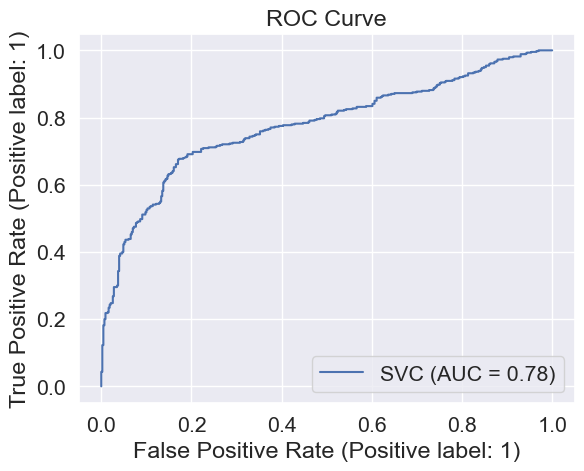

In [122]:
classifier = SVC(random_state=0, probability=True, C=1.75, gamma='scale', kernel='rbf')
i = 1
accs = []
f1s = []
recs = []
pres = []
cm = np.zeros((2,2))
time_start = time.time()
for train_index , test_index in KFold(n_splits=10, shuffle=True, random_state=0).split(x_train,y_train):  
    print("{",i,"FOLD}","Train Count:",len(train_index),"  Test Count:",len(test_index))
    i= i + 1 
    X_train,X_test = x_train.iloc[train_index],x_train.iloc[test_index]
    Y_train,Y_test = y_train.iloc[train_index],y_train.iloc[test_index]
    classifier.fit(X_train, Y_train)
    pred = classifier.predict(X_test)
    acc = accuracy_score(Y_test,pred)
    f1 = f1_score(Y_test,pred)
    rec = recall_score(Y_test,pred)
    pre = precision_score(Y_test,pred)
    print('Model: SVC     Accuracy:',acc,'     Precision:',pre,'     Recall:',rec,'     F1-Score:',f1)
    accs.append(acc)
    f1s.append(f1)
    recs.append(rec)
    pres.append(pre)
    cm = cm + confusion_matrix(Y_test,pred)

plot_roc_curve(classifier, X_test, Y_test)
plt.title('ROC Curve')
time_end = time.time()
time_svc = time_end - time_start
c_m_svc = np.round(cm / 10).astype(int)
acc_svc = np.mean(accs)
pre_svc = np.mean(pres)
rec_svc = np.mean(recs)
f1_svc = np.mean(f1s)
print("Mean_Accuracy:", np.mean(accs),"     Mean_Precision:", np.mean(pres),"     Mean_Recall:", np.mean(recs),"     Mean_F1-Score:", np.mean(f1s),"     Time:", time_svc)

<AxesSubplot: >

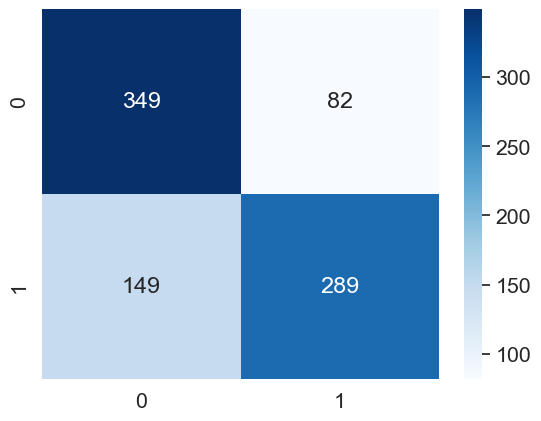

In [123]:
sns.heatmap(c_m_svc, annot=True, cmap='Blues', fmt='g')

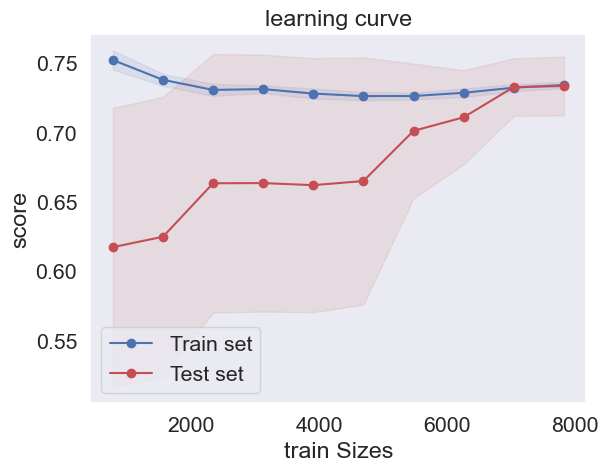

In [124]:
train_sizes,train_scores,test_scores=learning_curve(classifier,x_train,y_train,train_sizes=np.linspace(0.1,1,10),cv=10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.figure()
plt.title('learning curve')

plt.xlabel(u"train Sizes")
plt.ylabel(u"score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"Train set")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"Test set")

plt.legend(loc="best")

Decision Tree决策树

{ 1 FOLD} Train Count: 7823   Test Count: 870
Model: DecisionTree     Accuracy: 0.7758620689655172      Precision: 0.7775175644028103      Recall: 0.7685185185185185      F1-Score: 0.7729918509895227
{ 2 FOLD} Train Count: 7823   Test Count: 870
Model: DecisionTree     Accuracy: 0.7873563218390804      Precision: 0.7681159420289855      Recall: 0.8355855855855856      F1-Score: 0.8004314994606256
{ 3 FOLD} Train Count: 7823   Test Count: 870
Model: DecisionTree     Accuracy: 0.7896551724137931      Precision: 0.7535934291581109      Recall: 0.8534883720930233      F1-Score: 0.8004362050163577
{ 4 FOLD} Train Count: 7824   Test Count: 869
Model: DecisionTree     Accuracy: 0.8032220943613348      Precision: 0.8253588516746412      Recall: 0.7787810383747178      F1-Score: 0.8013937282229965
{ 5 FOLD} Train Count: 7824   Test Count: 869
Model: DecisionTree     Accuracy: 0.761795166858458      Precision: 0.765807962529274      Recall: 0.7534562211981567      F1-Score: 0.759581881533101
{ 6

d:\Anaconda3\envs\datamining\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


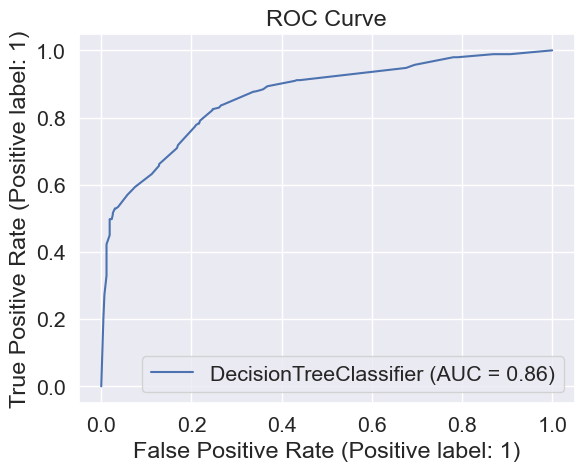

In [125]:
classifier = DecisionTreeClassifier(random_state=0, max_depth=7, criterion='gini')
i = 1
accs = []
f1s = []
recs = []
pres = []
cm = np.zeros((2,2))
time_start = time.time()
for train_index , test_index in KFold(n_splits=10, shuffle=True, random_state=0).split(x_train,y_train):  
    print("{",i,"FOLD}","Train Count:",len(train_index),"  Test Count:",len(test_index))
    i= i + 1 
    X_train,X_test = x_train.iloc[train_index],x_train.iloc[test_index]
    Y_train,Y_test = y_train.iloc[train_index],y_train.iloc[test_index]
    classifier.fit(X_train, Y_train)
    pred = classifier.predict(X_test)
    acc = accuracy_score(Y_test,pred)
    f1 = f1_score(Y_test,pred)
    rec = recall_score(Y_test,pred)
    pre = precision_score(Y_test,pred)
    print('Model: DecisionTree     Accuracy:',acc,'     Precision:',pre,'     Recall:',rec,'     F1-Score:',f1)
    accs.append(acc)
    f1s.append(f1)
    recs.append(rec)
    pres.append(pre)
    cm = cm + confusion_matrix(Y_test,pred)

plot_roc_curve(classifier, X_test, Y_test)
plt.title('ROC Curve')
time_end = time.time()
time_df = time_end - time_start
c_m_df = np.round(cm / 10).astype(int)
acc_df = np.mean(accs)
pre_df = np.mean(pres)
rec_df = np.mean(recs)
f1_df = np.mean(f1s)
print("Mean_Accuracy:", np.mean(accs),"     Mean_Precision:", np.mean(pres),"     Mean_Recall:", np.mean(recs),"     Mean_F1-Score:", np.mean(f1s),"     Time:", time_df)

<AxesSubplot: >

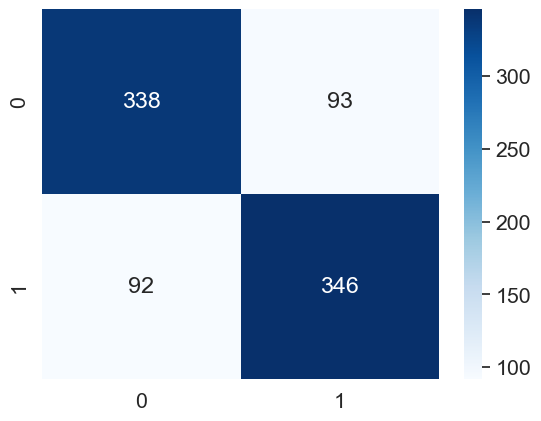

In [126]:
sns.heatmap(c_m_df, annot=True, cmap='Blues', fmt='g')

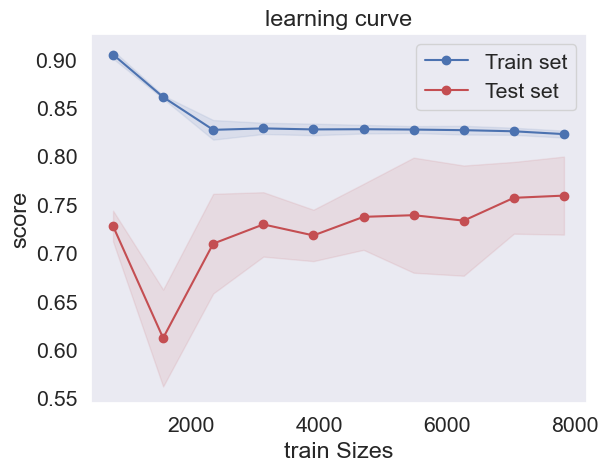

In [127]:
train_sizes,train_scores,test_scores=learning_curve(classifier,x_train,y_train,train_sizes=np.linspace(0.1,1,10),cv=10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.figure()
plt.title('learning curve')

plt.xlabel(u"train Sizes")
plt.ylabel(u"score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"Train set")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"Test set")

plt.legend(loc="best")

Random Forest随机森林

{ 1 FOLD} Train Count: 7823   Test Count: 870
Model: RandomForest     Accuracy: 0.8022988505747126      Precision: 0.8066037735849056      Recall: 0.7916666666666666      F1-Score: 0.7990654205607476
{ 2 FOLD} Train Count: 7823   Test Count: 870
Model: RandomForest     Accuracy: 0.7977011494252874      Precision: 0.8073394495412844      Recall: 0.7927927927927928      F1-Score: 0.8
{ 3 FOLD} Train Count: 7823   Test Count: 870
Model: RandomForest     Accuracy: 0.7977011494252874      Precision: 0.7926267281105991      Recall: 0.8      F1-Score: 0.7962962962962964
{ 4 FOLD} Train Count: 7824   Test Count: 869
Model: RandomForest     Accuracy: 0.807825086306099      Precision: 0.8333333333333334      Recall: 0.7787810383747178      F1-Score: 0.8051341890315054
{ 5 FOLD} Train Count: 7824   Test Count: 869
Model: RandomForest     Accuracy: 0.7779056386651323      Precision: 0.7671840354767184      Recall: 0.7972350230414746      F1-Score: 0.7819209039548024
{ 6 FOLD} Train Count: 7824   T

d:\Anaconda3\envs\datamining\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


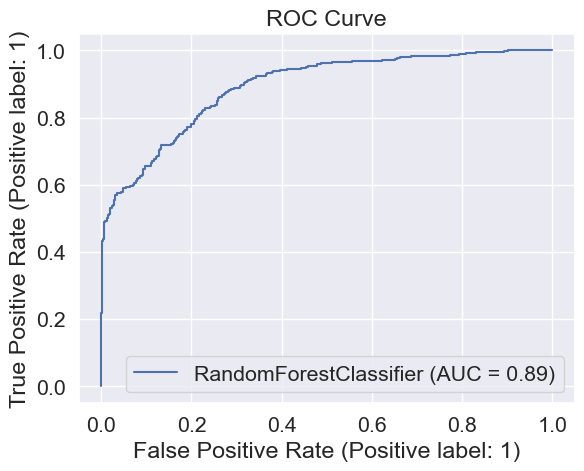

In [128]:
classifier = RandomForestClassifier(random_state=0, max_depth=12, n_estimators=250)
i = 1
accs = []
f1s = []
recs = []
pres = []
cm = np.zeros((2,2))
time_start = time.time()
for train_index , test_index in KFold(n_splits=10, shuffle=True, random_state=0).split(x_train,y_train):  
    print("{",i,"FOLD}","Train Count:",len(train_index),"  Test Count:",len(test_index))
    i= i + 1 
    X_train,X_test = x_train.iloc[train_index],x_train.iloc[test_index]
    Y_train,Y_test = y_train.iloc[train_index],y_train.iloc[test_index]
    classifier.fit(X_train, Y_train)
    pred = classifier.predict(X_test)
    acc = accuracy_score(Y_test,pred)
    f1 = f1_score(Y_test,pred)
    rec = recall_score(Y_test,pred)
    pre = precision_score(Y_test,pred)
    print('Model: RandomForest     Accuracy:',acc,'     Precision:',pre,'     Recall:',rec,'     F1-Score:',f1)
    accs.append(acc)
    f1s.append(f1)
    recs.append(rec)
    pres.append(pre)
    cm = cm + confusion_matrix(Y_test,pred)

plot_roc_curve(classifier, X_test, Y_test)
plt.title('ROC Curve')
time_end = time.time()
time_rf = time_end - time_start
c_m_rf = np.round(cm / 10).astype(int)
acc_rf = np.mean(accs)
pre_rf = np.mean(pres)
rec_rf = np.mean(recs)
f1_rf = np.mean(f1s)
print("Mean_Accuracy:", np.mean(accs),"     Mean_Precision:", np.mean(pres),"     Mean_Recall:", np.mean(recs),"     Mean_F1-Score:", np.mean(f1s),"     Time:",time_rf)

<AxesSubplot: >

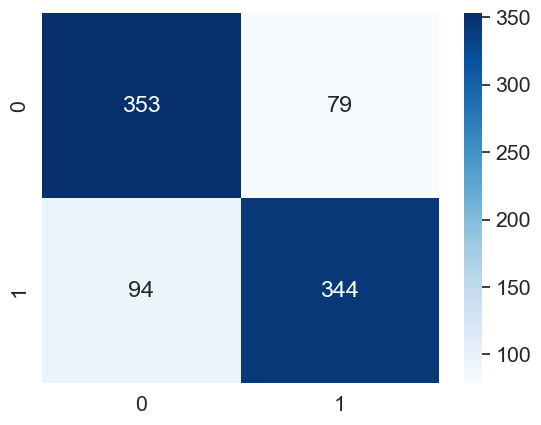

In [129]:
sns.heatmap(c_m_rf, annot=True, cmap='Blues', fmt='g')

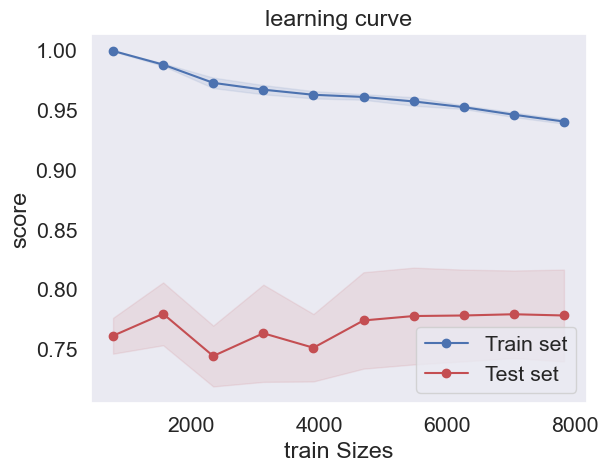

In [130]:
train_sizes,train_scores,test_scores=learning_curve(classifier,x_train,y_train,train_sizes=np.linspace(0.1,1,10),cv=10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.figure()
plt.title('learning curve')

plt.xlabel(u"train Sizes")
plt.ylabel(u"score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"Train set")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"Test set")

plt.legend(loc="best")

CatBoost 集成学习

{ 1 FOLD} Train Count: 7823   Test Count: 870


d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Model: CatBoost     Accuracy: 0.8149425287356322      Precision: 0.8031319910514542      Recall: 0.8310185185185185      F1-Score: 0.8168373151308305
{ 2 FOLD} Train Count: 7823   Test Count: 870


d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Model: CatBoost     Accuracy: 0.8103448275862069      Precision: 0.8052516411378556      Recall: 0.8288288288288288      F1-Score: 0.8168701442841289
{ 3 FOLD} Train Count: 7823   Test Count: 870


d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Model: CatBoost     Accuracy: 0.8264367816091954      Precision: 0.8177676537585421      Recall: 0.8348837209302326      F1-Score: 0.8262370540851554
{ 4 FOLD} Train Count: 7824   Test Count: 869


d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Model: CatBoost     Accuracy: 0.807825086306099      Precision: 0.8179723502304147      Recall: 0.801354401805869      F1-Score: 0.8095781071835804
{ 5 FOLD} Train Count: 7824   Test Count: 869


d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Model: CatBoost     Accuracy: 0.7940161104718066      Precision: 0.7765726681127982      Recall: 0.8248847926267281      F1-Score: 0.7999999999999999
{ 6 FOLD} Train Count: 7824   Test Count: 869


d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Model: CatBoost     Accuracy: 0.8135788262370541      Precision: 0.8376470588235294      Recall: 0.7928730512249443      F1-Score: 0.8146453089244852
{ 7 FOLD} Train Count: 7824   Test Count: 869


d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Model: CatBoost     Accuracy: 0.80897583429229      Precision: 0.8106904231625836      Recall: 0.8179775280898877      F1-Score: 0.8143176733780761
{ 8 FOLD} Train Count: 7824   Test Count: 869


d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Model: CatBoost     Accuracy: 0.8377445339470656      Precision: 0.8367346938775511      Recall: 0.8424657534246576      F1-Score: 0.8395904436860068
{ 9 FOLD} Train Count: 7824   Test Count: 869


d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Model: CatBoost     Accuracy: 0.8193325661680092      Precision: 0.805045871559633      Recall: 0.8297872340425532      F1-Score: 0.8172293364377182
{ 10 FOLD} Train Count: 7824   Test Count: 869


d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Model: CatBoost     Accuracy: 0.810126582278481      Precision: 0.8008752735229759      Recall: 0.8318181818181818      F1-Score: 0.8160535117056855
Mean_Accuracy: 0.8143323677631841      Mean_Precision: 0.8111689625237337      Mean_Recall: 0.8235892011310402      Mean_F1-Score: 0.8171358894815667      Time: 12.059264898300171


d:\Anaconda3\envs\datamining\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


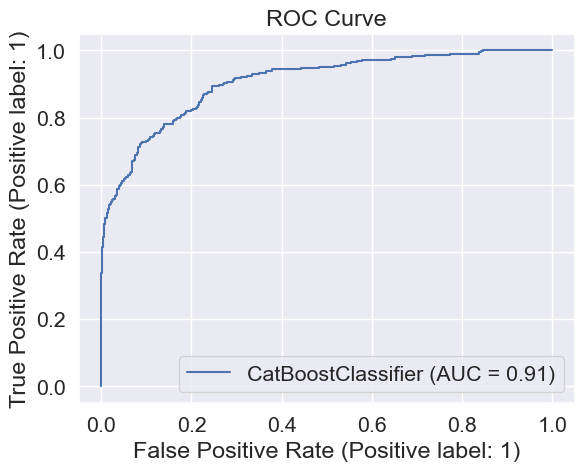

In [131]:
classifier = CatBoostClassifier(random_state=0, verbose=False, learning_rate=0.05, max_depth=8, n_estimators=200)
i = 1
accs = []
f1s = []
recs = []
pres = []
cm = np.zeros((2,2))
time_start = time.time()
for train_index , test_index in KFold(n_splits=10, shuffle=True, random_state=0).split(x_train,y_train):  
    print("{",i,"FOLD}","Train Count:",len(train_index),"  Test Count:",len(test_index))
    i= i + 1 
    X_train,X_test = x_train.iloc[train_index],x_train.iloc[test_index]
    Y_train,Y_test = y_train.iloc[train_index],y_train.iloc[test_index]
    classifier.fit(X_train, Y_train)
    pred = classifier.predict(X_test)
    acc = accuracy_score(Y_test,pred)
    f1 = f1_score(Y_test,pred)
    rec = recall_score(Y_test,pred)
    pre = precision_score(Y_test,pred)
    print('Model: CatBoost     Accuracy:',acc,'     Precision:',pre,'     Recall:',rec,'     F1-Score:',f1)
    accs.append(acc)
    f1s.append(f1)
    recs.append(rec)
    pres.append(pre)
    cm = cm + confusion_matrix(Y_test,pred)

plot_roc_curve(classifier, X_test, Y_test)
plt.title('ROC Curve')
time_end = time.time()
time_cb = time_end - time_start
c_m_cb = np.round(cm / 10).astype(int)
acc_cb = np.mean(accs)
pre_cb = np.mean(pres)
rec_cb = np.mean(recs)
f1_cb = np.mean(f1s)
print("Mean_Accuracy:", np.mean(accs),"     Mean_Precision:", np.mean(pres),"     Mean_Recall:", np.mean(recs),"     Mean_F1-Score:", np.mean(f1s),"     Time:",time_cb)

<AxesSubplot: >

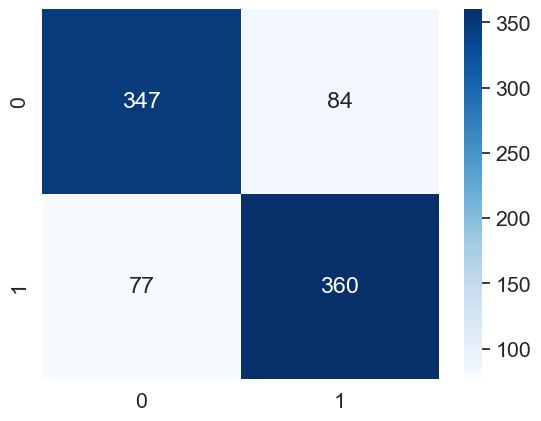

In [132]:
sns.heatmap(c_m_cb, annot=True, cmap='Blues', fmt='g')

d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


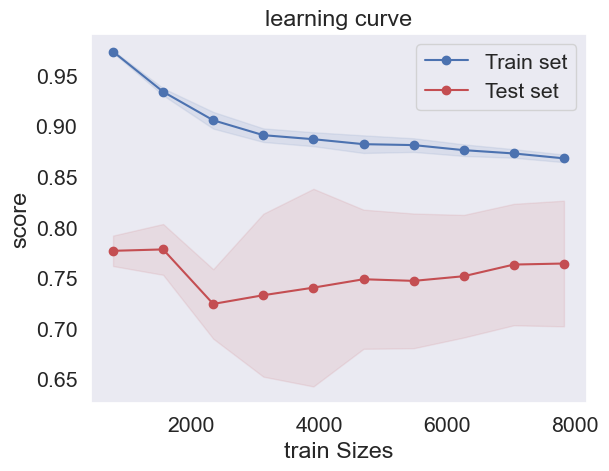

In [133]:
train_sizes,train_scores,test_scores=learning_curve(classifier,x_train,y_train,train_sizes=np.linspace(0.1,1,10),cv=10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.figure()
plt.title('learning curve')

plt.xlabel(u"train Sizes")
plt.ylabel(u"score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"Train set")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"Test set")

plt.legend(loc="best")

Naive Bayes 朴素贝叶斯

{ 1 FOLD} Train Count: 7823   Test Count: 870
Model: NaiveBayes     Accuracy: 0.764367816091954      Precision: 0.7645687645687645      Recall: 0.7592592592592593      F1-Score: 0.7619047619047619
{ 2 FOLD} Train Count: 7823   Test Count: 870
Model: NaiveBayes     Accuracy: 0.7459770114942529      Precision: 0.7766749379652605      Recall: 0.704954954954955      F1-Score: 0.7390791027154664
{ 3 FOLD} Train Count: 7823   Test Count: 870
Model: NaiveBayes     Accuracy: 0.7528735632183908      Precision: 0.7615571776155717      Recall: 0.727906976744186      F1-Score: 0.7443519619500594
{ 4 FOLD} Train Count: 7824   Test Count: 869
Model: NaiveBayes     Accuracy: 0.7502876869965478      Precision: 0.7927461139896373      Recall: 0.690744920993228      F1-Score: 0.7382388419782872
{ 5 FOLD} Train Count: 7824   Test Count: 869
Model: NaiveBayes     Accuracy: 0.7203682393555811      Precision: 0.7334963325183375      Recall: 0.6912442396313364      F1-Score: 0.711743772241993
{ 6 FOLD} Train

d:\Anaconda3\envs\datamining\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


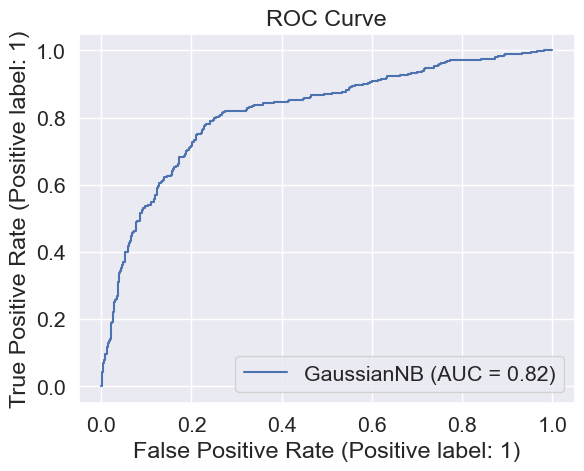

In [144]:
classifier = GaussianNB(var_smoothing=1e-07)
i = 1
accs = []
f1s = []
recs = []
pres = []
cm = np.zeros((2,2))
time_start = time.time()
for train_index , test_index in KFold(n_splits=10, shuffle=True, random_state=0).split(x_train,y_train):  
    print("{",i,"FOLD}","Train Count:",len(train_index),"  Test Count:",len(test_index))
    i= i + 1 
    X_train,X_test = x_train.iloc[train_index],x_train.iloc[test_index]
    Y_train,Y_test = y_train.iloc[train_index],y_train.iloc[test_index]
    classifier.fit(X_train, Y_train)
    pred = classifier.predict(X_test)
    acc = accuracy_score(Y_test,pred)
    f1 = f1_score(Y_test,pred)
    rec = recall_score(Y_test,pred)
    pre = precision_score(Y_test,pred)
    print('Model: NaiveBayes     Accuracy:',acc,'     Precision:',pre,'     Recall:',rec,'     F1-Score:',f1)
    accs.append(acc)
    f1s.append(f1)
    recs.append(rec)
    pres.append(pre)
    cm = cm + confusion_matrix(Y_test,pred)

plot_roc_curve(classifier, X_test, Y_test)
plt.title('ROC Curve')
time_end = time.time()
time_nb = time_end - time_start
c_m_nb = np.round(cm / 10).astype(int)
acc_nb = np.mean(accs)
pre_nb = np.mean(pres)
rec_nb = np.mean(recs)
f1_nb = np.mean(f1s)
print("Mean_Accuracy:", np.mean(accs),"     Mean_Precision:", np.mean(pres),"     Mean_Recall:", np.mean(recs),"     Mean_F1-Score:", np.mean(f1s),"     Time:",time_nb)

<AxesSubplot: >

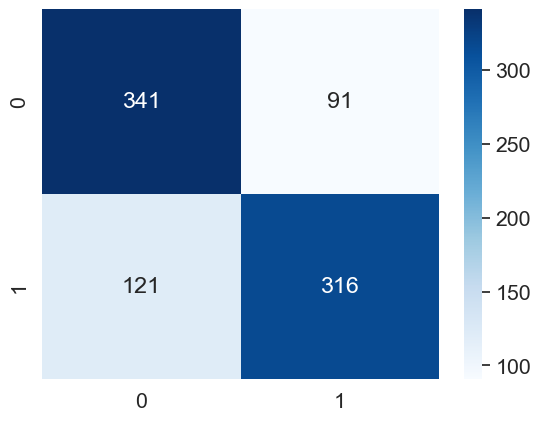

In [135]:
sns.heatmap(c_m_nb, annot=True, cmap='Blues', fmt='g')

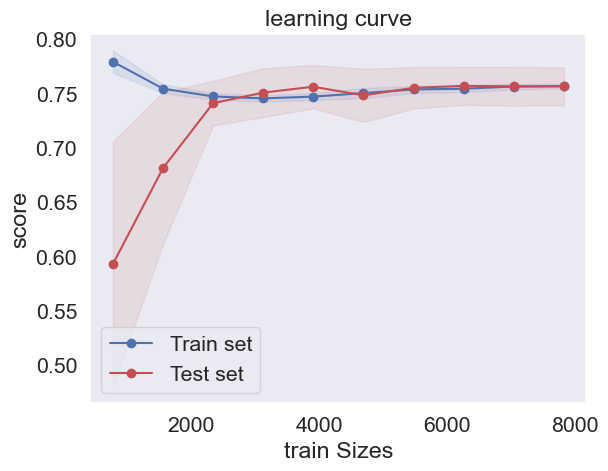

In [145]:
train_sizes,train_scores,test_scores=learning_curve(classifier,x_train,y_train,train_sizes=np.linspace(0.1,1,10),cv=10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title('learning curve')

plt.xlabel(u"train Sizes")
plt.ylabel(u"score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"Train set")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"Test set")

plt.legend(loc="best")

画图

Text(Naive Bayes, 0.7561, '0.7561')

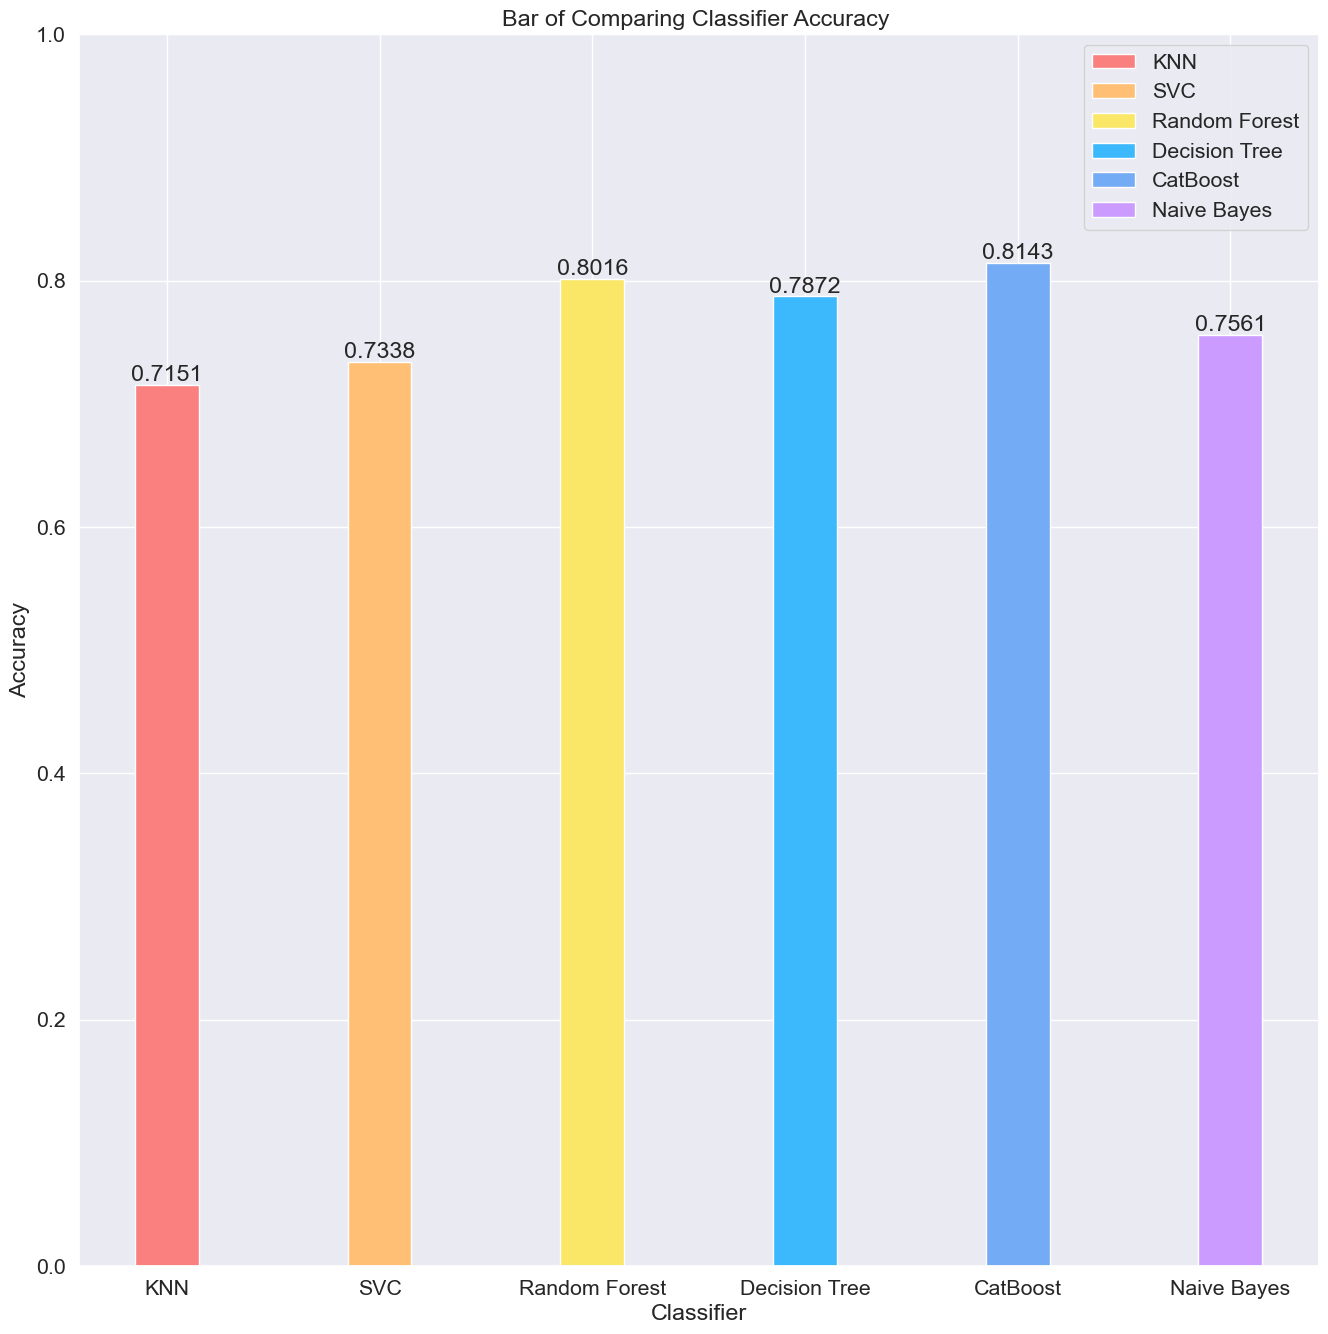

In [137]:
acc_knn = round(acc_knn,4)
acc_svc = round(acc_svc,4)
acc_rf = round(acc_rf,4)
acc_df = round(acc_df,4)
acc_cb = round(acc_cb,4)
acc_nb = round(acc_nb,4)

plt.figure(figsize=(16,16))
classifier_bar_knn = plt.bar("KNN",acc_knn, width=0.3, color=['#fa8080'], label = "KNN");
classifier_bar_svc = plt.bar("SVC",acc_svc, width=0.3, color=['#ffc076'], label = "SVC");
classifier_bar_rf = plt.bar("Random Forest",acc_rf, width=0.3, color=['#fae768'], label = "Random Forest");
classifier_bar_df = plt.bar("Decision Tree",acc_df, width=0.3, color=['#3cb9fc'], label = "Decision Tree");
classifier_bar_cb = plt.bar("CatBoost",acc_cb, width=0.3, color=['#73abf5'], label = "CatBoost");
classifier_bar_nb = plt.bar("Naive Bayes",acc_nb, width=0.3, color=['#cb9bff'], label = "Naive Bayes");

plt.title("Bar of Comparing Classifier Accuracy ")
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()

plt.text("KNN", acc_knn, acc_knn, ha='center', va='bottom')
plt.text("SVC", acc_svc, acc_svc, ha='center', va='bottom')
plt.text("Random Forest", acc_rf, acc_rf, ha='center', va='bottom')
plt.text("Decision Tree", acc_df, acc_df, ha='center', va='bottom')
plt.text("CatBoost", acc_cb, acc_cb, ha='center', va='bottom')
plt.text("Naive Bayes", acc_nb, acc_nb, ha='center', va='bottom')

In [138]:
pd.DataFrame(data=[ ['KNN',acc_knn,pre_knn,rec_knn,f1_knn,time_knn],
                    ['SVC',acc_svc,pre_svc,rec_svc,f1_svc,time_svc],
                    ['Random Forest',acc_rf,pre_rf,rec_rf,f1_rf,time_rf],
                    ['Decision Tree',acc_df,pre_df,rec_df,f1_df,time_df],
                    ['CatBoost',acc_cb,pre_cb,rec_cb,f1_cb,time_cb],
                    ['Naive Bayes',acc_nb,pre_nb,rec_nb,f1_nb,time_nb]],
            columns = ['Classifier','Mean_Accuracy','Mean_Precision','Mean_Recal','Mean_F1-Score','Running Time(s)'],
            index = [1,2,3,4,5,6])

,Classifier,Mean_Accuracy,Mean_Precision,Mean_Recal,Mean_F1-Score,Running Time(s)
1,KNN,0.7151,0.741273,0.667498,0.702177,0.613137
2,SVC,0.7338,0.778160,0.659946,0.714015,100.743812
3,Random Forest,0.8016,0.814292,0.786322,0.799697,16.315396
4,Decision Tree,0.7872,0.788545,0.790662,0.788867,0.307016
5,CatBoost,0.8143,0.811169,0.823589,0.817136,12.059265
6,Naive Bayes,0.7561,0.777445,0.723057,0.749048,0.091428


测试

In [146]:
KNN = KNeighborsClassifier(n_neighbors = 9, p=1)
SVM = SVC(random_state=0, probability=True, C=1.75, gamma='scale', kernel='rbf')
DT = DecisionTreeClassifier(random_state=0, max_depth=7, criterion='gini')
RF = RandomForestClassifier(random_state=0, max_depth=12, n_estimators=250)
CBT = CatBoostClassifier(random_state=0, verbose=False, learning_rate=0.05, max_depth=8, n_estimators=200)
NB = GaussianNB(var_smoothing=1e-07)

In [147]:
classifier = CBT.fit(X_train,Y_train)
submission = classifier.predict(x_test)
PASSENGER_ID = test_set[['PassengerId']]
data = {
    'PassengerId': np.array(PASSENGER_ID).reshape(len(PASSENGER_ID)),
    'Transported': np.array(submission).astype('bool')
}

submission_df = pd.DataFrame(data=data).reset_index()
submission_df.drop(columns=['index'], inplace=True, axis=1)
submission_df.to_csv("..\dataset\spaceship-titanic\\submission_CBT.csv", index=False)

d:\Anaconda3\envs\datamining\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [ ]:
classifier = KNN.fit(X_train,Y_train)
submission = classifier.predict(x_test)
PASSENGER_ID = test_set[['PassengerId']]
data = {
    'PassengerId': np.array(PASSENGER_ID).reshape(len(PASSENGER_ID)),
    'Transported': np.array(submission).astype('bool')
}

submission_df = pd.DataFrame(data=data).reset_index()
submission_df.drop(columns=['index'], inplace=True, axis=1)
submission_df.to_csv("..\dataset\spaceship-titanic\\submission_KNN.csv", index=False)

In [ ]:
classifier = SVM.fit(X_train,Y_train)
submission = classifier.predict(x_test)
PASSENGER_ID = test_set[['PassengerId']]
data = {
    'PassengerId': np.array(PASSENGER_ID).reshape(len(PASSENGER_ID)),
    'Transported': np.array(submission).astype('bool')
}

submission_df = pd.DataFrame(data=data).reset_index()
submission_df.drop(columns=['index'], inplace=True, axis=1)
submission_df.to_csv("..\dataset\spaceship-titanic\\submission_SVM.csv", index=False)

In [ ]:
classifier = DT.fit(X_train,Y_train)
submission = classifier.predict(x_test)
PASSENGER_ID = test_set[['PassengerId']]
data = {
    'PassengerId': np.array(PASSENGER_ID).reshape(len(PASSENGER_ID)),
    'Transported': np.array(submission).astype('bool')
}

submission_df = pd.DataFrame(data=data).reset_index()
submission_df.drop(columns=['index'], inplace=True, axis=1)
submission_df.to_csv("..\dataset\spaceship-titanic\\submission_DT.csv", index=False)

In [ ]:
classifier = RF.fit(X_train,Y_train)
submission = classifier.predict(x_test)
PASSENGER_ID = test_set[['PassengerId']]
data = {
    'PassengerId': np.array(PASSENGER_ID).reshape(len(PASSENGER_ID)),
    'Transported': np.array(submission).astype('bool')
}

submission_df = pd.DataFrame(data=data).reset_index()
submission_df.drop(columns=['index'], inplace=True, axis=1)
submission_df.to_csv("..\dataset\spaceship-titanic\\submission_RF.csv", index=False)

In [ ]:
classifier = NB.fit(X_train,Y_train)
submission = classifier.predict(x_test)
PASSENGER_ID = test_set[['PassengerId']]
data = {
    'PassengerId': np.array(PASSENGER_ID).reshape(len(PASSENGER_ID)),
    'Transported': np.array(submission).astype('bool')
}

submission_df = pd.DataFrame(data=data).reset_index()
submission_df.drop(columns=['index'], inplace=True, axis=1)
submission_df.to_csv("..\dataset\spaceship-titanic\\submission_NB.csv", index=False)